In [1]:
import pandas as pd
import numpy as np
import time, datetime
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import linregress

In [2]:
us = pd.read_csv("Input Data/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv", encoding="ISO-8859-1")
glob = pd.read_csv("Input Data/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv", encoding="ISO-8859-1")

In [3]:
sanfran = us.loc[us['Province_State'].str.contains("San Francisco") | us["Admin2"].str.contains("San Francisco")]
tampa = us.loc[us['Province_State'].str.contains("Florida") & us["Admin2"].str.contains("Hillsborough")]
chi = us.loc[us['Province_State'].str.contains("Illinois") & us["Admin2"].str.contains("Cook")]
nyc = us.loc[us['Province_State'].str.contains("New York") & us["Admin2"].str.contains("New York")]
htown = us.loc[us['Province_State'].str.contains("Texas") & us["Admin2"].str.contains("Harris")]
htown = htown.drop(htown[htown["Admin2"] == "Harrison"].index)
det = us.loc[us['Province_State'].str.contains("Michigan") & us["Admin2"].str.contains("Wayne")]
sea = us.loc[us['Province_State'].str.contains("Washington") & us["Admin2"].str.contains("King")]
bos = us.loc[us['Province_State'].str.contains("Massachusetts") & us["Admin2"].str.contains("Suffolk")]
mil = us.loc[us['Province_State'].str.contains("Wisconsin") & us["Admin2"].str.contains("Milwaukee")]
us_merged = pd.concat([sanfran, tampa, chi, nyc, htown, det, sea, bos, mil])
us_merged = us_merged.drop(columns=['UID','iso2','iso3','code3','FIPS','Country_Region','Combined_Key'])
us_merged.rename({'Admin2': 'Province/State', 'Province_State': 'Country/Region', 'Long_': 'Long'}, axis=1, inplace=True)

In [4]:
glob = glob.fillna("")
tor = glob.loc[glob['Province/State'].str.contains("Ontario")]
ita = glob.loc[glob['Country/Region'].str.contains("Italy")]
spa = glob.loc[glob['Country/Region'].str.contains("Spain")]
fra = glob.loc[glob['Country/Region'].str.contains("France")]
fra = fra.drop(fra[fra["Province/State"].str.contains("French")].index)
fra = fra.drop(fra[fra["Province/State"].str.contains("Saint")].index)
fra = fra.drop(fra[fra["Province/State"].str.contains("St")].index)
fra = fra.drop(fra[fra["Province/State"].str.contains("n")].index)
fra = fra.drop(fra[fra["Province/State"].str.contains("o")].index)
ger = glob.loc[glob['Country/Region'].str.contains("Germany")]
uk = glob.loc[glob['Country/Region'].str.contains("United Kingdom")]
uk = uk.drop(uk[uk["Province/State"].str.contains("Isl")].index)
uk = uk.drop(uk[uk["Province/State"].str.contains("a")].index)
nor = glob.loc[glob['Country/Region'].str.contains("Norway")]
swe = glob.loc[glob['Country/Region'].str.contains("Sweden")]
ira = glob.loc[glob['Country/Region'].str.contains("Iran")]
tur = glob.loc[glob['Country/Region'].str.contains("Turkey")]
beijing = glob.loc[glob['Country/Region'].str.contains("China") & glob['Province/State'].str.contains("Beijing")]
hubei = glob.loc[glob['Country/Region'].str.contains("China") & glob['Province/State'].str.contains("Hubei")]
kor = glob.loc[glob['Country/Region'].str.contains("Korea")]
mal = glob.loc[glob['Country/Region'].str.contains("Malaysia")]
syd = glob.loc[glob['Country/Region'].str.contains("Australia") & glob['Province/State'].str.contains("New South Wales")]
glob_df = pd.concat([tor, ita, spa, fra, ger, uk, nor, swe, ira, tur, beijing, hubei, kor, mal, syd])
# glob_df

In [5]:
data = pd.concat([us_merged,glob_df])
data["Name"] = [x[0] + ', ' + x[1] if x[0] != '' else x[1] for x in zip(data["Province/State"], data["Country/Region"])]
cols = [data.columns[-1]] + [col for col in data if col != data.columns[-1]]
data = data[cols]
data = data.drop(['Province/State', 'Country/Region'], axis=1)
data = data.reset_index(drop=True)
# data

In [6]:
data

,Name,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20
0,"San Francisco, California",37.752151,-122.438567,0,0,0,0,0,0,0,...,622,676,724,797,857,872,957,987,1013,1019
1,"Hillsborough, Florida",27.927656,-82.320132,0,0,0,0,0,0,0,...,608,626,644,671,690,759,813,819,869,878
2,"Cook, Illinois",41.841448,-87.816588,0,0,1,1,1,1,1,...,8728,10520,10520,12472,13417,14585,15474,16323,17306,18087
3,"New York, New York",40.767273,-73.971526,0,0,0,0,0,0,0,...,76876,81803,87028,92384,98308,103208,106763,110465,118302,123146
4,"Harris, Texas",29.858649,-95.393395,0,0,0,0,0,0,0,...,2146,2341,3047,3261,3561,3629,3744,3907,4097,4306
5,"Wayne, Michigan",42.280984,-83.281255,0,0,0,0,0,0,0,...,9045,9626,10093,10539,10951,11164,11648,12209,12544,12544
6,"King, Washington",47.491379,-121.834613,1,1,1,1,1,1,1,...,3486,3688,3886,4117,4262,4426,4426,4549,4620,4697
7,"Suffolk, Massachusetts",42.327951,-71.078504,0,0,0,0,0,0,0,...,3245,3600,4041,4534,4926,5359,5579,5872,6279,6820
8,"Milwaukee, Wisconsin",43.004861,-87.967332,0,0,0,0,0,0,0,...,1323,1416,1484,1575,1653,1710,1743,1795,1870,1947
9,"Ontario, Canada",51.253800,-85.323200,0,0,0,0,1,1,1,...,4726,5276,5759,6237,6648,7049,7470,7953,8447,9840


In [7]:
data_t = data.T.reset_index(drop=True)
data_t1 = data.T
data_t

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,"San Francisco, California","Hillsborough, Florida","Cook, Illinois","New York, New York","Harris, Texas","Wayne, Michigan","King, Washington","Suffolk, Massachusetts","Milwaukee, Wisconsin","Ontario, Canada",...,United Kingdom,Norway,Sweden,Iran,Turkey,"Beijing, China","Hubei, China","Korea, South",Malaysia,"New South Wales, Australia"
1,37.7522,27.9277,41.8414,40.7673,29.8586,42.281,47.4914,42.328,43.0049,51.2538,...,55.3781,60.472,63,32,38.9637,40.1824,30.9756,36,2.5,-33.8688
2,-122.439,-82.3201,-87.8166,-73.9715,-95.3934,-83.2813,-121.835,-71.0785,-87.9673,-85.3232,...,-3.436,8.4689,16,53,35.2433,116.414,112.271,128,112.5,151.209
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,14,444,1,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,22,444,1,0,0
5,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,36,549,2,0,0
6,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,41,761,2,3,0
7,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,68,1058,3,4,3
8,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,80,1423,4,4,4
9,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,91,3554,4,4,4


In [8]:
data_t2 = data_t.loc[3:,:]
data_t2.columns = list(data_t.loc[0,:])
data_t2 = data_t2.reset_index(drop=True)
data_t2

,"San Francisco, California","Hillsborough, Florida","Cook, Illinois","New York, New York","Harris, Texas","Wayne, Michigan","King, Washington","Suffolk, Massachusetts","Milwaukee, Wisconsin","Ontario, Canada",...,United Kingdom,Norway,Sweden,Iran,Turkey,"Beijing, China","Hubei, China","Korea, South",Malaysia,"New South Wales, Australia"
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,14,444,1,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,22,444,1,0,0
2,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,36,549,2,0,0
3,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,41,761,2,3,0
4,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,68,1058,3,4,3
5,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,80,1423,4,4,4
6,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,91,3554,4,4,4
7,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,111,3554,4,7,4
8,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,114,4903,4,8,4
9,0,0,2,0,0,0,1,0,0,3,...,2,0,1,0,0,139,5806,11,8,4


In [9]:
data_t3 = data_t2.loc[1:].reset_index(drop=True).div(data_t2[:85].replace({0: None}))-1
data_t3 = data_t3.fillna(0)
data_t3['Date'] = list(data_t1.index[4:])
data_t3 = data_t3.set_index('Date')
data_t3

,"San Francisco, California","Hillsborough, Florida","Cook, Illinois","New York, New York","Harris, Texas","Wayne, Michigan","King, Washington","Suffolk, Massachusetts","Milwaukee, Wisconsin","Ontario, Canada",...,United Kingdom,Norway,Sweden,Iran,Turkey,"Beijing, China","Hubei, China","Korea, South",Malaysia,"New South Wales, Australia"
Date,,,,,,,,,,,,,,,,,,,,,
1/23/20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.571429,0.000000,0.000000,0.000000,0.000000
1/24/20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.636364,0.236486,1.000000,0.000000,0.000000
1/25/20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.138889,0.386157,0.000000,0.000000,0.000000
1/26/20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.658537,0.390276,0.500000,0.333333,0.000000
1/27/20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.176471,0.344991,0.333333,0.000000,0.333333
1/28/20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.137500,1.497540,0.000000,0.000000,0.000000
1/29/20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.219780,0.000000,0.000000,0.750000,0.000000
1/30/20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.027027,0.379572,0.000000,0.142857,0.000000
1/31/20,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.219298,0.184173,1.750000,0.000000,0.000000


In [10]:
data_t4 = data_t2
data_t4['Date'] = list(data_t1.index[3:])
data_t4 = data_t4.set_index('Date')
data_t4

,"San Francisco, California","Hillsborough, Florida","Cook, Illinois","New York, New York","Harris, Texas","Wayne, Michigan","King, Washington","Suffolk, Massachusetts","Milwaukee, Wisconsin","Ontario, Canada",...,United Kingdom,Norway,Sweden,Iran,Turkey,"Beijing, China","Hubei, China","Korea, South",Malaysia,"New South Wales, Australia"
Date,,,,,,,,,,,,,,,,,,,,,
1/22/20,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,14,444,1,0,0
1/23/20,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,22,444,1,0,0
1/24/20,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,36,549,2,0,0
1/25/20,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,41,761,2,3,0
1/26/20,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,68,1058,3,4,3
1/27/20,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,80,1423,4,4,4
1/28/20,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,91,3554,4,4,4
1/29/20,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,111,3554,4,7,4
1/30/20,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,114,4903,4,8,4


In [11]:
data_t3.to_csv("Data Output/Percent_Change_Data.csv")

In [12]:
data_t4.to_csv("Data Output/Total_Number_Data.csv")

In [13]:
seoul_temp = pd.read_csv("Input Data/temp_kor.csv")
manual_temp = pd.read_csv("Input Data/temp_manual_enter.csv")

In [14]:
per_change_kor = data_t3["Korea, South"].replace(0,np.nan)
per_change_chi = data_t3["Cook, Illinois"].replace(0,np.nan)
per_change_tampa = data_t3["Hillsborough, Florida"].replace(0,np.nan)

In [15]:
seoul_temp = seoul_temp.set_index('Date')
manual_temp = manual_temp.set_index('Date')
seoul_df = pd.concat([seoul_temp['seoul_avg'], data_t3['Korea, South']], axis=1, sort=False)
seoul_df = seoul_df[seoul_df['Korea, South'] != 0]
tampa_df = pd.concat([manual_temp['Tampa'], data_t3['Hillsborough, Florida']], axis=1, sort=False)
tampa_df = tampa_df[tampa_df['Hillsborough, Florida'] != 0]
chi_df = pd.concat([manual_temp['Chicago'], data_t3['Cook, Illinois']], axis=1, sort=False)
chi_df = chi_df[chi_df['Cook, Illinois'] != 0]

The r-squared is: -0.1631695151210587


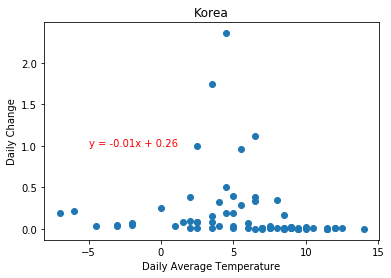

In [16]:
x = seoul_df['seoul_avg']
y = seoul_df['Korea, South']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x,y)
plt.annotate(line_eq,(-5,1),fontsize=10,color="red")
plt.xlabel("Daily Average Temperature")
plt.ylabel("Daily Change")
plt.title("Korea")
plt.savefig('Chart Images/seoul_scatterplot.png')
print(f'The r-squared is: {rvalue}')

The r-squared is: -0.36913551978929476


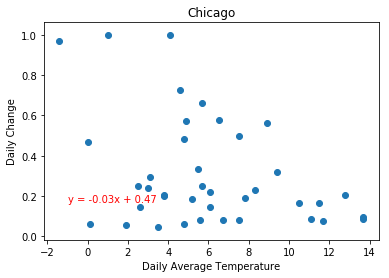

In [17]:
x = chi_df['Chicago']
y = chi_df['Cook, Illinois']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x,y)
plt.annotate(line_eq,(-1,0.17),fontsize=10,color="red")
plt.xlabel("Daily Average Temperature")
plt.ylabel("Daily Change")
plt.title("Chicago")
plt.savefig('Chart Images/chicago_scatterplot.png')
print(f'The r-squared is: {rvalue}')

The r-squared is: -0.0038527111389345765


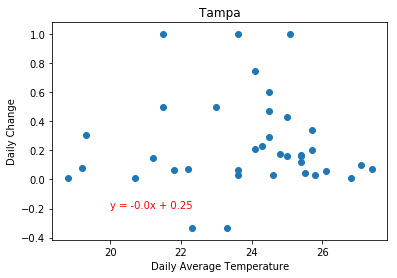

In [18]:
x = tampa_df['Tampa']
y = tampa_df['Hillsborough, Florida']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x,y)
plt.annotate(line_eq,(20,-0.2),fontsize=10,color="red")
plt.xlabel("Daily Average Temperature")
plt.ylabel("Daily Change")
plt.title("Tampa")
plt.savefig('Chart Images/tampa_scatterplot.png')
print(f'The r-squared is: {rvalue}')

In [19]:
seoul_df.columns = ['temp','change']
chi_df.columns = ['temp','change']
tampa_df.columns = ['temp', 'change']
combined = seoul_df.append(chi_df, sort=False).append(tampa_df, sort=False)
combined

,temp,change
Date,,
1/24/20,2.5,1.000000
1/26/20,4.5,0.500000
1/27/20,6.5,0.333333
1/31/20,3.5,1.750000
2/1/20,2.0,0.090909
2/2/20,0.0,0.250000
2/4/20,-2.0,0.066667
2/5/20,-7.0,0.187500
2/6/20,-6.0,0.210526


The r-squared is: -0.06073069690927502


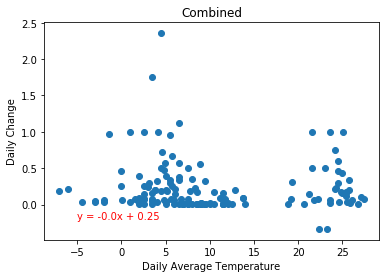

In [20]:
x = combined['temp']
y = combined['change']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x,y)
plt.annotate(line_eq,(-5,-0.2),fontsize=10,color="red")
plt.xlabel("Daily Average Temperature")
plt.ylabel("Daily Change")
plt.title("Combined")
plt.savefig('Chart Images/combined_scatterplot.png')
print(f'The r-squared is: {rvalue}')

In [21]:
# temp_results = {}
# for i in range(data.shape[0]):
#     for s in list(data_t.loc[3:, 'index']):
#         start = int(time.mktime(datetime.datetime.strptime(s, "%m/%d/%y").timetuple()))
#         city = data.loc[i, 'Name']
#         lat = data.loc[i, 'Lat']
#         lon = data.loc[i, 'Long']
#         cnt = 24
#         url = f'http://history.openweathermap.org/data/2.5/history/city?lat={lat}&lon={lon}&type=hour&start={start}&cnt={cnt}&appid=83d37db208e34e2caa33a401de5f19a5'
#         result = 5.0
#         temp_results[city] = result